## 🏎️ Araba Yarışı

---

Bu projede, Gymnasium'dan [Car Racing ortamı](https://gymnasium.farama.org/environments/box2d/car_racing/) ile çalışacaksınız. Görev, prosedürel olarak oluşturulan bir pistte arabayla sürüş yaparak, yolda kalırken turları verimli bir şekilde tamamlamaktır.

İki tür pekiştirmeli öğrenme ajanı eğiteceksiniz: bir **DQN ajanı** ve bir **PPO ajanı**.

---

### 🚧 Bu Projeyi Farklı Kılan Nedir?

**CliffWalking** gibi **ayrık eylem uzayları** kullanan önceki ortamların aksine, Car Racing ortamı **sürekli eylem uzayı** kullanır.

- Ajanlar şunları kontrol etmeli:
  - **Direksiyon** (sol/sağ)
  - **Hızlanma** (gaz)
  - **Fren yapma**

Bu şu anlama gelir:
- ❌ DQN, ince ayarlı sürekli kontrolde zorlanır  
- ✅ PPO çok daha uygun, çünkü sürekli politikaları doğrudan öğrenebilir

🧠 Bu proje, **Politika Gradyanı yöntemleri** olan PPO'nun neden sürekli kontrol problemlerinde tercih edildiğini ve DQN'u yanlış ortama zorladığınızda ne olduğunu anlamanıza yardımcı olacak.

---
Bu proje için ihtiyaç duyacağımız tüm paketleri içe aktararak başlayalım:

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

---
### Bölüm 1 : CarRacing üzerinde DQN

Bu bölümde, şimdiye kadar öğrendiğiniz her şeyi uygulayacaksınız — ancak bu sefer Gymnasium'dan `CarRacing-v3` ortamı üzerinde.

#### 🧠 İlginç olan ne?  
→ `CarRacing-v3` **sürekli** eylem uzayına sahip.  
→ DQN sadece **ayrık** eylemlerle çalışır.  

Bu görev DQN'un temel bir sınırını vurgular.

#### 📝 İzlenecek Adımlar:

1. 🚗 Ortamı Yükle: Ortamı yüklemek için `gym.make('CarRacing-v3')` kullan.
2. 🧩 DummyVecEnv ile Sar.
3. ⚙️ DQN Modelini Başlat.
4. 🪵 EpisodeRewardLogger Kullan:
    - Her bölümün sonunda ödülleri kaydetmek için aşağıda sağlanan özel geri çağırma.
    - `.learn()` çağrılırken geri çağırma olarak geçirin.
5. ⏱️ 10.000 Zaman Adımı için Eğit

#### ⚠️ Ne Olur?

```python
ValueError: DQN policies can only be used with environments that have a discrete action space. Your action space is of type Box.
```

Bu hatayı gördüğünüzde, bir sonraki bölüme geçmeye hazırsınız!

In [3]:
# Define a custom callback to log rewards at the end of each episode.
class EpisodeRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(EpisodeRewardLogger, self).__init__(verbose)
        # List to store the total rewards for each episode.
        self.episode_rewards = []
        # Variable to accumulate rewards for the current episode.
        self.episode_reward = 0

    # This method is called after every step taken in the environment.
    def _on_step(self) -> bool:
        # Add the reward from the current step to the episode reward accumulator.
        self.episode_reward += self.locals['rewards'][0]

        # Check if the episode is done (i.e., the environment has reached a terminal state).
        if self.locals['dones'][0]:
            # If the episode is done, append the accumulated reward to the episode_rewards list.
            self.episode_rewards.append(self.episode_reward)
            # Reset the episode reward accumulator to zero for the next episode.
            self.episode_reward = 0

        # Return True to continue training, False would stop the training.
        return True

In [4]:
# ---------------------------------------------------------
# Bölüm 1: DQN ile Hata Üretme Deneyi
# ---------------------------------------------------------

# 1. Ortamı Yükle
# render_mode='rgb_array' arka planda işlem yapmamızı sağlar
env = DummyVecEnv([lambda: gym.make("CarRacing-v3", render_mode="rgb_array")])

print("🚗 Ortam Hazırlandı. DQN Modeli başlatılıyor...")

try:
    # 2. DQN Modelini Başlat
    # 'CnnPolicy' kullanıyoruz çünkü girdi bir görüntü (piksel)
    model = DQN("CnnPolicy", env, verbose=1)

    # 3. Geri çağrımı (Callback) başlat
    callback = EpisodeRewardLogger()

    # 4. Modeli Eğit (Burası çalışmayacak)
    print("🏋️ Eğitim başlıyor...")
    model.learn(total_timesteps=10000, callback=callback)

except Exception as e:
    print("\n" + "="*60)
    print("🚨 BEKLENEN HATA YAKALANDI!")
    print("="*60)
    print(f"Hata Mesajı: {e}")
    print("="*60)
    print("DQN, 'Box' (Sürekli) tipindeki eylem uzaylarını desteklemez.")

🚗 Ortam Hazırlandı. DQN Modeli başlatılıyor...
Using cpu device
Wrapping the env in a VecTransposeImage.

🚨 BEKLENEN HATA YAKALANDI!
Hata Mesajı: The algorithm only supports (<class 'gymnasium.spaces.discrete.Discrete'>,) as action spaces but Box([-1.  0.  0.], 1.0, (3,), float32) was provided
DQN, 'Box' (Sürekli) tipindeki eylem uzaylarını desteklemez.


/home/egkpnr/.pyenv/versions/3.12.9/envs/reinforcement-env/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### ❓ Bu neden hata veriyor?

- → **DQN** **ayrık eylem kümesi** gerektirir — *sol*, *sağ*, *yukarı*, *aşağı* gibi.  
- → **CarRacing** **sürekli eylem uzayı** kullanır — *direksiyon*, *hızlanma* ve *frenleme* için gerçel değerlerle.

📉 Bu yüzden **DQN bu ortamda çalışmaz** — sürekli kontrol görevleri için inşa edilmemiş.

---
### 🧠 Bölüm 2: Araba Yarışında Politika Gradyanı

Bu bölümde, daha önce yaptığınız işlemi tekrarlayacaksınız — ancak bu sefer **Politika Gradyanı yöntemi** kullanarak:  
Stable Baselines3'ten `MlpPolicy` ile `PPO` modeli.

#### 📝 İzlenecek Adımlar:

1. 🚗 Ortamı Yükle: Ortamı yüklemek için `gym.make('CarRacing-v3')` kullan.
2. 🧩 DummyVecEnv ile Sar.
3. ⚙️ PPO Modelini Başlat.
4. 🪵 EpisodeRewardLogger Kullan:
    - Her bölümün sonunda ödülleri kaydetmek için aşağıda sağlanan özel geri çağırma.
    - `.learn()` çağrılırken geri çağırma olarak geçirin.
5. ⏱️ 10.000 Zaman Adımı için Eğit

In [5]:
# ---------------------------------------------------------
# Bölüm 2: PPO ile Doğru Eğitim
# ---------------------------------------------------------

# 1. Ortamı Yükle
# render_mode='rgb_array' eğitimi hızlandırmak için (arka planda çalışır)
env = DummyVecEnv([lambda: gym.make("CarRacing-v3", render_mode="rgb_array")])

print("✅ Ortam Hazır. PPO Modeli başlatılıyor...")

# 2. PPO Modelini Başlat
# Not: Görüntü işlediğimiz için 'MlpPolicy' yerine 'CnnPolicy' kullanıyoruz.
model = PPO(
    "CnnPolicy", 
    env, 
    verbose=1,
    learning_rate=0.0003  # Genellikle PPO için iyi bir başlangıç değeri
)

# 3. Logger'ı başlat
callback = EpisodeRewardLogger()

# 4. Eğitimi Başlat (10.000 adım)
print("🏎️ PPO Eğitimi Başlıyor (10.000 adım)...")
start_time = time.time()

model.learn(total_timesteps=10000, callback=callback, progress_bar=True)

end_time = time.time()
print(f"🏁 Eğitim tamamlandı! Süre: {end_time - start_time:.2f} saniye")

# 5. Modeli Kaydet
model.save("ppo_carracing_10k")
print("💾 Model 'ppo_carracing_10k' olarak kaydedildi.")


✅ Ortam Hazır. PPO Modeli başlatılıyor...
Using cpu device
Wrapping the env in a VecTransposeImage.


Output()

🏎️ PPO Eğitimi Başlıyor (10.000 adım)...


-----------------------------
| time/              |      |
|    fps             | 191  |
|    iterations      | 1    |
|    time_elapsed    | 10   |
|    total_timesteps | 2048 |
-----------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 141          |
|    iterations           | 2            |
|    time_elapsed         | 28           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0034747554 |
|    clip_fraction        | 0.0399       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.00592      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.175        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00421     |
|    std                  | 0.998        |
|    value_loss           | 0.64         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 3           |
|    time_elapsed         | 45          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.008020719 |
|    clip_fraction        | 0.0779      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | 0.0887      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.195       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00674    |
|    std                  | 0.993       |
|    value_loss           | 0.623       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 4           |
|    time_elapsed         | 63          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012362035 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.22       |
|    explained_variance   | 0.102       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.231       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0127     |
|    std                  | 0.982       |
|    value_loss           | 0.412       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 5            |
|    time_elapsed         | 80           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0066022445 |
|    clip_fraction        | 0.0696       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.2         |
|    explained_variance   | 0.164        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.152        |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00811     |
|    std                  | 0.978        |
|    value_loss           | 0.498        |
------------------------------------------


🏁 Eğitim tamamlandı! Süre: 86.03 saniye
💾 Model 'ppo_carracing_10k' olarak kaydedildi.


👉 Ödülleri zaman içinde çizin.

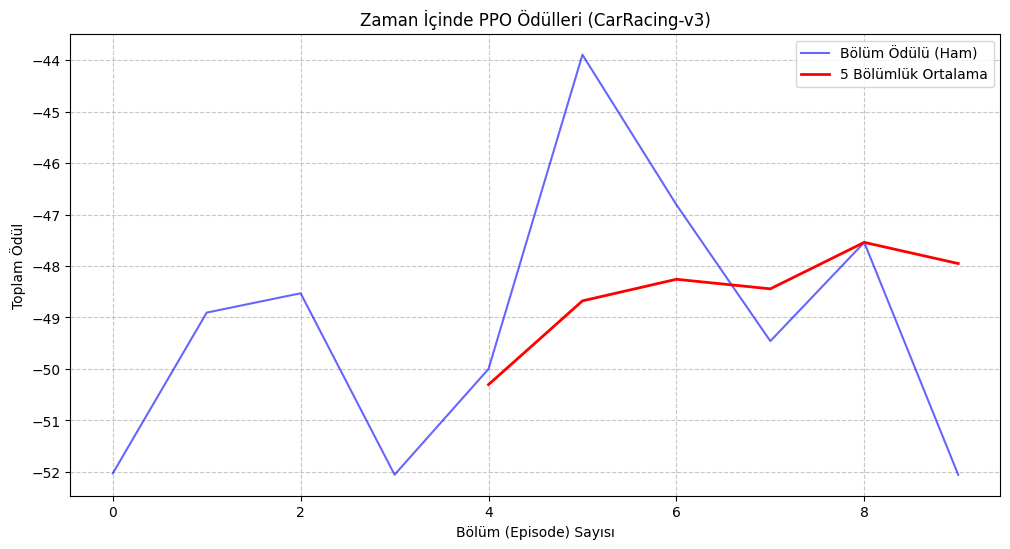

In [6]:
# 📊 Ödülleri Çizdirme

plt.figure(figsize=(12, 6))

# 1. Ham Ödül Verisi (Her bölümün sonucu)
plt.plot(callback.episode_rewards, label='Bölüm Ödülü (Ham)', alpha=0.6, color='blue')

# 2. Hareketli Ortalama (Trendi görmek için)
# Eğer yeterli veri varsa son 5 bölümün ortalamasını kırmızı çizgiyle gösterelim
window_size = 5
if len(callback.episode_rewards) >= window_size:
    moving_avg = np.convolve(callback.episode_rewards, np.ones(window_size)/window_size, mode='valid')
    # Hareketli ortalamayı grafiğe hizalamak için x eksenini ayarlıyoruz
    plt.plot(range(window_size - 1, len(callback.episode_rewards)), moving_avg, color='red', linewidth=2, label=f'{window_size} Bölümlük Ortalama')

plt.title('Zaman İçinde PPO Ödülleri (CarRacing-v3)')
plt.xlabel('Bölüm (Episode) Sayısı')
plt.ylabel('Toplam Ödül')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### 📊 Politika Gradyanı Eğitim Günlüğü Metriklerini Anlama

PPO gibi algoritmalarla eğitim yaparken, çeşitli günlük metrikleri performansı ve eğitim kararlılığını takip etmenize yardımcı olur.

#### ⏱️ Zamanla İlgili Metrikler

- **fps** → Saniye başına kare — model ne kadar hızlı eğitiliyor. Yüksek = daha iyi.  
- **iterations** → Tamamlanan parametre güncelleme döngüsü sayısı.  
- **time_elapsed** → Eğitimin başlamasından bu yana geçen toplam süre (saniye).  
- **total_timesteps** → Ajan tarafından deneyimlenen toplam ortam adımı sayısı.

#### 🧠 Eğitim Süreci Metrikleri

- **approx_kl** → Bir güncellemeden sonra politikanın ne kadar değiştiği.  
  - Düşük = daha kararlı öğrenme.  
- **clip_fraction** → PPO'nun güncelleme kırpmasının ne sıklıkta uygulandığı.  
- **clip_range** → Politika güncellemelerini kırpmak için kullanılan aralık (ani değişiklikleri önler).  
- **entropy_loss** → Eylem seçimindeki rastgeleliği ölçer.  
  - Yüksek = daha fazla keşif.  
- **explained_variance** → Değer tahminlerinin gerçek getirilerle ne kadar eşleştiği.  
  - 1'e yakın = daha iyi.  
- **learning_rate** → Ağırlık güncellemelerinin boyutunu kontrol eder.  
- **loss** → Genel eğitim kaybı — iyileşmeyi takip etmeye yardımcı olur.  
- **n_updates** → Toplam model ağırlığı güncellemesi sayısı.  
- **policy_gradient_loss** → Politikanın ne kadar iyileştiğini gösterir.  
- **value_loss** → Değer fonksiyonu tahminlerinin ne kadar doğru olduğunu ölçer.

#### 🔍 Bu Metrikleri Nasıl Yorumlarız

- **Yüksek `entropy_loss`** → Ajan daha fazla keşfediyor (çok rastgele olabilir).  
- **Düşük `explained_variance`** → Değer tahminleri yanlış.  
- **Azalan `loss`** → Zaman içinde etkili öğrenme olduğunu gösterir.

---

### 🧠 Politika Gradyanı Neden CarRacing için İdeal

CarRacing pürüzsüz ve hassas kontrol gerektirir — bu da **Politika Gradyanı yöntemleri** olan **PPO**'yu mükemmel uyum haline getirir.

#### 1. 🎯 Sürekli Eylemler için Tasarlandı  
- PPO **gerçek değerli eylemleri** doğrudan işler.  
- CarRacing'de, ajan sadece sol veya sağı seçmek değil, *ne kadar direksiyon kırılacağını*, *ne kadar sert fren yapılacağını* ve *ne kadar gaz verileceğini* seçmesi gerekir.

#### 2. 🧠 Politikayı Doğrudan Öğrenir  
- Eylemlerin değerini tahmin eden DQN'un aksine, PPO *nasıl* davranacağını öğrenir.  
- Bu, yüksek hızlı sürüş ortamlarında kritik olan **daha esnek ve uyarlanabilir davranışlara** olanak tanır.

#### 3. 🪶 Pürüzsüz ve Hassas Kontrol  
- PPO **ince ayarlı kararları** destekler — sürüş görevlerinde gereken ince ayarlamalar için mükemmel.  
- Artık ani, hep ya da hiç hareketler yok.

---

### ❌ DQN Neden Burada İyi Bir Uyum Değil

- **DQN ayrık eylem uzayı gerektirir** (ör. *yukarı*, *aşağı*, *sol*, *sağ*).  
- CarRacing **sürekli eylem uzayı** kullanır — eylemlerin gerçel sayılar olduğu.

DQN kullanmak için, direksiyon/fren/gaz kombinasyonlarının tamamını **ayrıklaştırmanız** gerekir:  
🧱 Verimsiz ve nadiren etkili olan bir geçici çözüm.

---

### ⚖️ Özet: Politika Gradyanının Parladığı Yer Burası

| Yöntem           | CarRacing'deki Gücü                                    |
|------------------|-----------------------------------------------------------|
| 🧠 Politika Gradyanı | Sürekli eylemleri doğrudan öğrenir — ayrıklaştırma gerekmez. |
| ❌ DQN             | Sürekli eylemler için inşa edilmemiş — uyum sağlamakta zorlanır.         |